In [1]:
import os
import pandas as pd
import numpy as np
import networkx as nx
from sklearn.metrics.pairwise import cosine_distances
import ndex2
import json
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
base_dir = "../data/embedding"
output_path = "../data/embedding_graph"
output_file = os.path.join(output_path, "if.cx")
os.makedirs(output_path, exist_ok=True)
G = nx.Graph()

In [3]:
def get_edge_dataframe(G):
    edge_data = []
    for u, v, attrs in G.edges(data=True):
        row = {"gene1": u, "gene2": v}
        row.update(attrs)
        edge_data.append(row)
    return pd.DataFrame(edge_data)

In [4]:
treatment_dfs = {}

for treatment in os.listdir(base_dir):
    treatment_path = os.path.join(base_dir, treatment)
    emb_file = os.path.join(treatment_path, "image_emd.tsv")

    if not os.path.isfile(emb_file):
        print(f"❌ Skipping {treatment}: image_emd.tsv not found.")
        continue

    print(f"🔍 Processing treatment: {treatment}")
    df = pd.read_csv(emb_file, sep="\t")
    df = df[df["id"].notna() & (df["id"] != "NEGATIVE")]
    embedding_cols = df.columns[1:]
    df[embedding_cols] = df[embedding_cols].apply(pd.to_numeric)

    # Average embeddings
    df_avg = df.groupby("id")[embedding_cols].mean().reset_index()
    treatment_dfs[treatment] = df_avg

❌ Skipping .DS_Store: image_emd.tsv not found.
🔍 Processing treatment: paclitaxel
🔍 Processing treatment: untreated
🔍 Processing treatment: vorinostat


In [5]:
# Get only genes common to all treatments
common_genes = set.intersection(*[set(df["id"]) for df in treatment_dfs.values()])
print(f"✅ Found {len(common_genes)} common genes across treatments")

✅ Found 460 common genes across treatments


In [6]:
for treatment, df_avg in treatment_dfs.items():
    df_avg = df_avg[df_avg["id"].isin(common_genes)].reset_index(drop=True)
    embedding_cols = df_avg.columns[1:]

    gene_names = df_avg["id"].tolist()
    emb_matrix = df_avg[embedding_cols].values
    distance_matrix = cosine_distances(emb_matrix)

    print(f"📐 Building cosine distance graph for {treatment}")
    for i in range(len(gene_names)):
        for j in range(i + 1, len(gene_names)):
            gene_i = gene_names[i]
            gene_j = gene_names[j]
            dist = distance_matrix[i, j]

            if not G.has_edge(gene_i, gene_j):
                G.add_edge(gene_i, gene_j)
            G[gene_i][gene_j][f"cosine_distance_{treatment}"] = dist

📐 Building cosine distance graph for paclitaxel
📐 Building cosine distance graph for untreated
📐 Building cosine distance graph for vorinostat


In [7]:
# Postprocessing: compute variability across treatments
print("📊 Computing variability in cosine distances across treatments...")

treatment_attrs = [attr for attr in next(iter(G.edges(data=True)))[-1] if attr.startswith("cosine_distance_")]

for u, v, data in G.edges(data=True):
    dists = [data.get(attr) for attr in treatment_attrs if data.get(attr) is not None]

    if len(dists) >= 2:  # Only calculate if we have at least 2 values
        data["cosine_distance_min"] = min(dists)
        data["cosine_distance_max"] = max(dists)
        data["cosine_distance_range"] = max(dists) - min(dists)
        data["cosine_distance_mean"] = sum(dists) / len(dists)
        data["cosine_distance_std"] = np.std(dists)
    else:
        # Set to None or 0 if not enough values
        data["cosine_distance_min"] = None
        data["cosine_distance_max"] = None
        data["cosine_distance_range"] = None
        data["cosine_distance_mean"] = None
        data["cosine_distance_std"] = None

📊 Computing variability in cosine distances across treatments...


In [8]:
ndex_graph = ndex2.create_nice_cx_from_networkx(G)

# Get the CX (list of CX aspects, not BytesIO)
cx_aspect_list = ndex_graph.to_cx()

# Save the CX JSON to a file
with open(output_file, "w") as f:
    json.dump(cx_aspect_list, f, indent=2)

print(f"✅ Graph saved to {output_file}")

Generating CX
✅ Graph saved to ../data/embedding_graph/if.cx


In [9]:
df_edges = get_edge_dataframe(G)

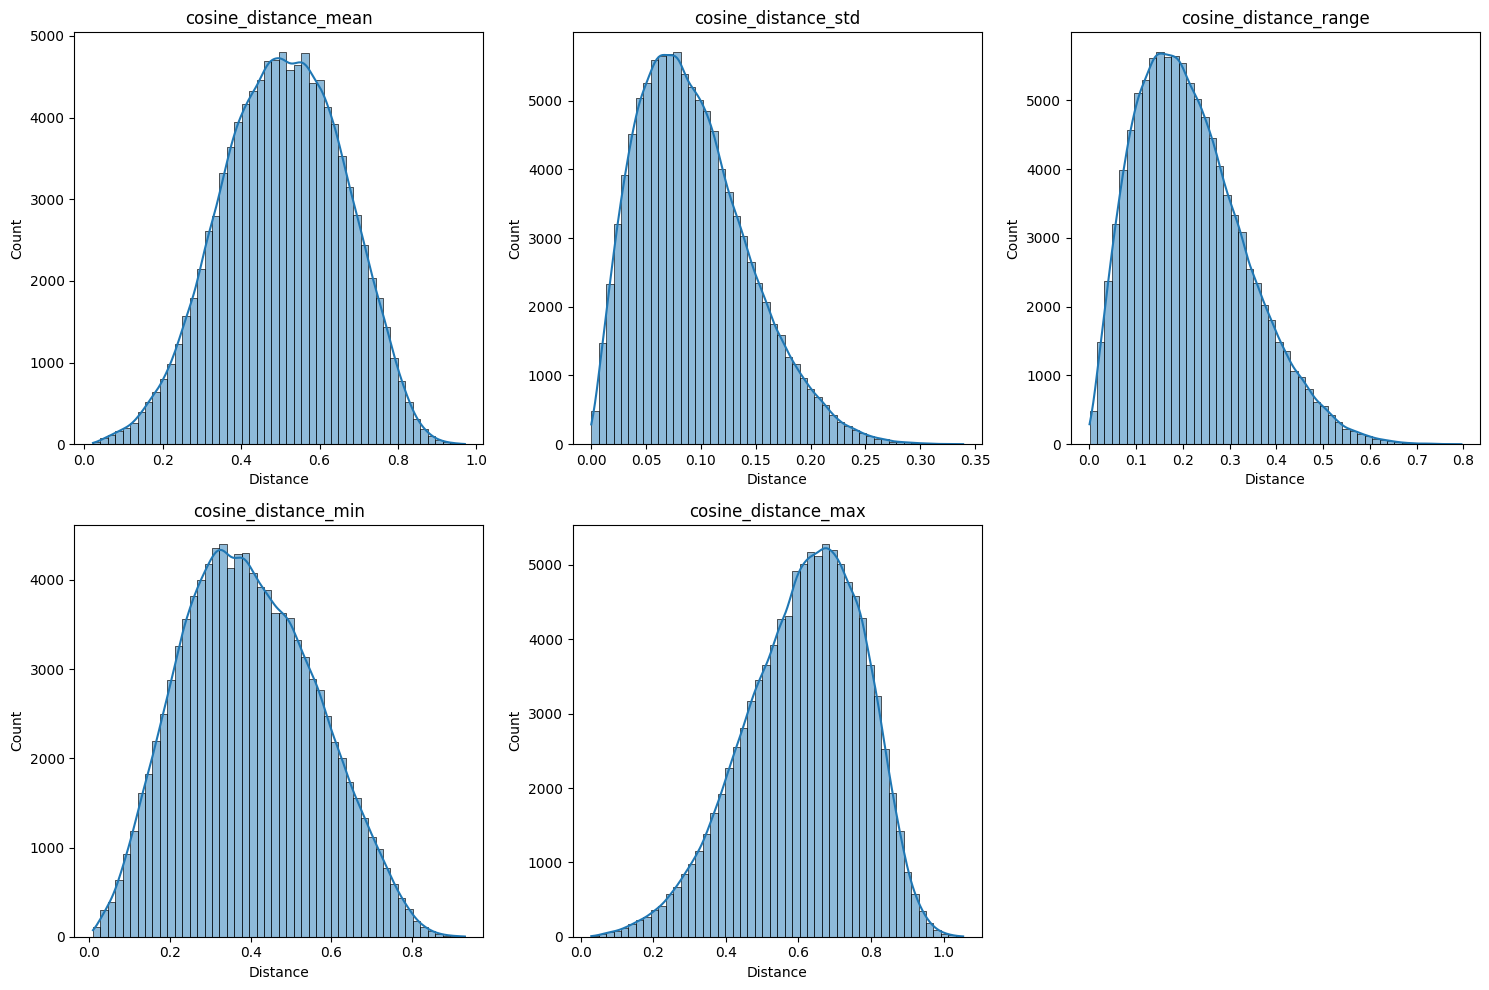

In [10]:
summary_metrics = [
    "cosine_distance_mean",
    "cosine_distance_std",
    "cosine_distance_range",
    "cosine_distance_min",
    "cosine_distance_max"
]

plt.figure(figsize=(15, 10))
for i, metric in enumerate(summary_metrics, 1):
    plt.subplot(2, 3, i)
    sns.histplot(df_edges[metric].dropna(), bins=50, kde=True)
    plt.title(metric)
    plt.xlabel("Distance")
    plt.ylabel("Count")

plt.tight_layout()
plt.show()

In [11]:
print(df_edges[[
    "cosine_distance_min",
    "cosine_distance_max",
    "cosine_distance_mean",
    "cosine_distance_range",
    "cosine_distance_std"
]].describe())

       cosine_distance_min  cosine_distance_max  cosine_distance_mean  \
count        105570.000000        105570.000000         105570.000000   
mean              0.396924             0.614209              0.506141   
std               0.164859             0.161143              0.153811   
min               0.008804             0.029353              0.022571   
25%               0.272797             0.507258              0.397649   
50%               0.387320             0.629503              0.509051   
75%               0.515445             0.734782              0.618838   
max               0.931014             1.053467              0.970435   

       cosine_distance_range  cosine_distance_std  
count          105570.000000        105570.000000  
mean                0.217285             0.093041  
std                 0.118016             0.050520  
min                 0.000219             0.000097  
25%                 0.127220             0.054519  
50%                 0.201396  

In [12]:
top_var = df_edges.sort_values("cosine_distance_std", ascending=False).head(10)
print("🔎 Top 10 most variable gene pairs across treatments:")
print(top_var[["gene1", "gene2", "cosine_distance_std", "cosine_distance_range"]])

🔎 Top 10 most variable gene pairs across treatments:
           gene1    gene2  cosine_distance_std  cosine_distance_range
5827        ACO1     SGTA             0.339003               0.795930
5575        ACO1     ECI1             0.337652               0.748147
73939      HDAC8    YWHAG             0.328615               0.722771
104088   SMARCA5     SPTB             0.327356               0.715187
13358     AKR1B1  ARHGEF1             0.325149               0.722571
28804      BACH1    PMPCB             0.323851               0.722323
35853        CBL     CTSC             0.322713               0.740904
74981       HIP1     KRT8             0.320888               0.682509
5387        ACLY  SMARCA5             0.316066               0.710845
103363  SERPINB1     SGTA             0.315802               0.772570
